# Audio2Map
This is an encoder-decoder model based off of seq2seq.

It takes in an audio file for the music as an mp3 and outputs a fully functional map for the hit rhythm game Osu!

In [16]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from functools import reduce

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_features = 8
STOP = torch.full((1, num_features), -1, dtype=torch.float32)

cuda:0


## Preprocessing

Here, we transform the input to a Constant-Q spectrogram spanning C1 to roughly C7. Then, for training, we obtain the pkl file containing the output vector representing the target output map.

We also obtain the difficulty for our target output to feed into the decoder, when deployed, this will be input from the user.

In [18]:
import datetime
import traceback

def convert_to_spectrogram(filename):
    try:
        targetSampleRate = 11025
        y, sr = librosa.load(filename, sr=targetSampleRate)
        C = np.abs(librosa.cqt(y, sr=targetSampleRate, n_bins=84, bins_per_octave=12))
        S = librosa.amplitude_to_db(C, ref=np.max)
        #plot the spectrogram

        '''plt.figure(figsize=(12, 4))
        librosa.display.specshow(S, sr=targetSampleRate, x_axis='time', y_axis='cqt_note')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Constant-Q power spectrogram')
        plt.tight_layout()
        plt.show()'''
        return S
    except:
        tsprint("ERROR: cannot convert " + filename + " to spectrogram.")
        traceback.print_exc()


def get_pkl(filename):
    try:
        return pickle.load(open(filename, 'rb'))
    except:
        tsprint("ERROR: .pkl file does not exist.")
        return -1

def tsprint(s):
    print("[" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "] " + s)

def parse_difficulty(filename):
    if(not os.path.isfile(filename)):
        tsprint("ERROR: map file does not exist. Removing.")
        os.remove("pickles/" + filename.split("/")[1].split(".")[0] + ".pkl")
        return -1

    with open(filename, "r") as f:
        try:
            lines = f.readlines()
        except:
            tsprint("ERROR: cannot read lines of .osu file.")


    difficulty = [-1,-1,-1,-1,-1,-1]

    for line in lines:
        #difficulty
        if line.startswith("HPDrainRate"): difficulty[0] = float(line.split(":", 1)[1])
        elif line.startswith("CircleSize"): difficulty[1] = float(line.split(":", 1)[1])
        elif line.startswith("OverallDifficulty"): difficulty[2] = float(line.split(":", 1)[1])
        elif line.startswith("ApproachRate"): difficulty[3] = float(line.split(":", 1)[1])
        elif line.startswith("SliderMultiplier"): difficulty[4] = float(line.split(":", 1)[1])
        elif line.startswith("SliderTickRate"): difficulty[5] = float(line.split(":", 1)[1])
        elif not (line.startswith("[Difficulty]")): break

    #check if all the difficulty stats are there
    for val in difficulty:
        if val == -1:
            tsprint("ERROR: Not a valid osu! map due to insufficient stats. Removed file " + filename + ".")
            os.remove(filename)
            os.remove("pickles/" + filename.split("/")[1].split(".")[0] + ".pkl")
            return -1


    return torch.tensor(difficulty)

# TODO: Deprecate
def load_data():
    inputs = []
    diffs = []
    targets = []

    curr_length = 0
    counter = 0

    if os.path.isfile("loaded_save.pkl"):
        inputs, diffs, targets = pickle.load(open("loaded_save.pkl", 'rb'))
        curr_length = len(inputs)


    for pickle_root, pickle_dirs, pickle_files in os.walk("pickles"):
        for pickle_file in pickle_files:
            counter += 1
            if counter < curr_length: continue

            tsprint("Parsing file " + pickle_file)
            inputs.append(convert_to_spectrogram(os.path.join("audio/", pickle_file.split("_")[0] + ".mp3")))
            diffs.append(parse_difficulty("maps/" + pickle_file.split(".")[0] + ".osu"))
            targets.append(get_pkl("pickles/" + pickle_file))

            if counter % 10 == 0:
                pickle.dump([inputs, diffs, targets], open("loaded_save.pkl", 'wb'))
                tsprint("Saved progress.")
                tsprint("Parsed " + str(counter) + " files.")

    return inputs, diffs, targets

In [19]:
from torch.utils.data import Dataset

class Audio2Map(Dataset):
     def __init__(self, input_dir, maps_dir, target_dir):
        self.in_dir = input_dir
        self.maps_dir = maps_dir
        self.tar_dir = target_dir
        self.deleted_counter = 0
     def __len__(self):
        return len([name for name in os.listdir(self.tar_dir) if os.path.isfile(os.path.join(self.tar_dir, name))])
     def __getitem__(self, idx):
        # use the listdir() index 5Head
        # Get the current map name w/o .osu
        files = [name for name in os.listdir(self.tar_dir) if os.path.isfile(os.path.join(self.tar_dir, name))]
        idx -= self.deleted_counter
        idx = min(idx, len(files) - 1)
        print(f"files length: {len(files)}, index: {idx}")
        currfile = files[idx][:-4]
        spec = convert_to_spectrogram(os.path.join(self.in_dir, currfile.split('_', 1)[0] + ".mp3"))
        while(type(spec) == type(None)):
            idx += 1
            currfile = files[idx][:-4]
            spec = convert_to_spectrogram(os.path.join(self.in_dir, currfile.split('_', 1)[0] + ".mp3"))
            if isinstance(spec, int):
                print(f'Could not get item at index {idx} due to parsing spectrogram.') 
                return -1
        input = torch.tensor(spec.T).float()
        diff = parse_difficulty(os.path.join(self.maps_dir, currfile + ".osu"))
        if isinstance(diff, int):
            print(f'Could not get item at index {idx} due to parsing difficulty.') 
            return -1
        diff = torch.t(parse_difficulty(os.path.join(self.maps_dir, currfile + ".osu"))).float()
        print(f"filename: {currfile}" )
        #print(os.path.join(self.tar_dir, currfile + ".pkl"))
        #print(get_pkl(os.path.join(self.tar_dir, currfile + ".pkl")))
        out = get_pkl(os.path.join(self.tar_dir, currfile + ".pkl"))[0].to_dense().float()
        if isinstance(out, int):
            print(f'Could not get item at index {idx} due to parsing pkl.') 
            return -1
        #out = torch.cat((out, STOP), 0)
        return input, diff, out

In [20]:
from torch.utils.data import random_split
# Now get the data >:D
#inputs, diffs, targets = load_data() #pickle.load(open("loaded_save.pkl", 'rb'))
a2m_data = Audio2Map("audio/", "maps/", "pickles/")

test_split = 0.2
train_data, test_data = random_split(a2m_data, [1-test_split, test_split])

In [21]:
for mp3file in os.listdir("audio/"):
    if not mp3file.split(".")[0] + "_0.osu" in os.listdir("maps/"):
        os.remove("audio/" + mp3file)

for mapfile in os.listdir("maps/"):
    if not mapfile.split("_")[0] + ".mp3" in os.listdir("audio/"):
        os.remove("maps/" + mapfile)

for pklfile in os.listdir("pickles/"):
    if not pklfile.split(".")[0] + ".osu" in os.listdir("maps/"):
        os.remove("pickles/" + pklfile)
        

In [22]:
from torch.utils.data import DataLoader

# Must sample individually due to each input and output being different sizes :(
train_dl = DataLoader(train_data, batch_size = None, batch_sampler = None, shuffle = True)
test_dl = DataLoader(test_data, batch_size = None, batch_sampler = None, shuffle = True)
# Output from dataloader is a list of size 3 containing a single input, difficulty, and output

In [23]:
from torch import nn
from torch.nn import functional as F
"""
- Given a song, we can generate a spectrogram
- Take the spectrogram and produce a list of times (rythmic beats)
"""
# Encoder
audio_dim = 84
hidden_dim = 64

# Use LSTM to predict the note timings of the song
from torch import nn
from torch.nn import functional as F
"""
- Given a song, we can generate a spectrogram
- Take the spectrogram and produce a list of times (rythmic beats)
"""
# Encoder
audio_dim = 84
hidden_dim = 64

# Use a CNN to turn the spectrogram into rhythm timings
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, hidden_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 3 * 3)
        x = self.fc1(x)

In [24]:
# Decoder
from math import floor
class Decoder(nn.Module):
    def __init__(self, dropout=0.2):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(num_features + 6, hidden_dim, num_layers=2, batch_first=True, device=device)
        self.dropout = nn.Dropout(dropout)
        self.hiddenfc = nn.Linear(hidden_dim, hidden_dim//2, device=device)
        self.outputfc = nn.Linear(hidden_dim//2, num_features, device=device)

    def forward(self, encoder_out, encoder_hc, difficulty, target=None):
        decoder_input = torch.zeros((1, num_features + 6), device=device)
        decoder_hidden = encoder_hc
        decoder_outputs = []

        prev_percent = 0
        #currStop = torch.cat((STOP.to(device), difficulty.unsqueeze(0)), 1)

        #while(not torch.equal(decoder_input, currStop)):
        iter = target.shape[0] if target != None else librosa.get_duration(S=encoder_out.T, sr=11025)*100
        # (num samples/sr)*1000 = time in ms
        print(f'Requires {int(iter)} iterations')
        for i in range(int(iter)):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_output = torch.round(decoder_output)
            decoder_outputs.append(decoder_output)

            if target is not None:
                curr_percent = floor(((i+1)/target.shape[0])*100)
                if curr_percent > prev_percent:
                    prev_percent = curr_percent
                    #print(f"Training...{curr_percent}%")
                decoder_input = torch.cat((target[i], difficulty), 0).unsqueeze(0)
            else:
                if (i+1) % 1000 == 0:
                    print(f"Timestep: {i+1}")
                decoder_input = torch.cat((decoder_output, difficulty.unsqueeze(0)), 1).detach()

        decoder_outputs = torch.cat(decoder_outputs, 0)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, x, hc):
        x, hc = self.lstm(x, hc)
        drp = self.dropout(x)
        hidden = self.hiddenfc(drp)
        out = self.outputfc(hidden)
        return out, hc

## Training Time!

In [25]:
from torch.optim import Adam
# Create models and offload to GPU for processing, if available
enc = Encoder(0.4).to(device)
dec = Decoder(0.4).to(device)

def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

print_model_size(enc)
print_model_size(dec)

model size: 0.293MB
model size: 0.214MB


In [26]:
import time
def train_epoch(data, encoder, decoder, encoder_opt, decoder_opt, lossfunc):
    # For now, data is a tuple of (x, diff, y)
    total_loss = 0
    for i, sample in enumerate(data):
        tsprint(f"Current sample {i+1}")
        # Put data onto the GPU if available, otherwise its just on cpu unlucky
        if isinstance(sample, int): 
            try:
                data.deleted_counter += 1
            except:
                print("balls")
            continue
        x = sample[0].to(device)
        diff = sample[1].to(device)
        y = sample[2].to(device)

        encoder_opt.zero_grad()
        decoder_opt.zero_grad()

        encoder_outputs, encoder_hc = encoder(x)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hc, diff, target=y)

        loss = lossfunc(decoder_outputs, y)
        loss.backward()

        encoder_opt.step()
        decoder_opt.step()

        total_loss += loss.item()
        print("Sample " + str(i + 1) + " trained successfully!")

        if i % 10 == 0:
            torch.save(enc.state_dict(), 'encoder.pth')
            torch.save(dec.state_dict(), 'decoder.pth')

    return total_loss/len(data)

def train(data, encoder, decoder, epochs=10, learning_rate=0.01):
    start = time.time()
    losshistory = []

    lossfunc = nn.MSELoss()

    enc_opt = Adam(enc.parameters(), lr=1e-4)
    dec_opt = Adam(dec.parameters(), lr=1e-4)
    for epoch in range(epochs):
        tsprint(f"Epoch: {epoch+1}")
        loss = train_epoch(data, encoder, decoder, enc_opt, dec_opt, lossfunc)
        curr_time = time.time()
        losshistory.append(loss)
        print(f"Loss: {loss} Time: {curr_time - start}")
    return losshistory

In [27]:
def get_mem_req(enc, dec):
    # register forward hooks to check intermediate activation size
    acts = []
    for name, module in enc.named_modules():
        if name == 'classifier' or name == 'features':
            continue
        module.register_forward_hook(lambda m, input, output: acts.append(output[0].detach()))
    for name, module in dec.named_modules():
        if name == 'classifier' or name == 'features':
            continue
        module.register_forward_hook(lambda m, input, output: acts.append(output[0].detach()))

    # execute single training step
    X, diff, y_true = next(iter(train_dl))
    # Forward pass
    y_hat, hc = enc(X[:10000])
    y_hat, _, _ = dec(y_hat, hc, diff, target=y_true[-10000:])
    loss = nn.MSELoss()(y_hat, y_true[-10000:])
    # Backward pass
    enc_opt = Adam(enc.parameters(), lr=0.01)
    dec_opt = Adam(dec.parameters(), lr=0.01)
    enc_opt.zero_grad()
    dec_opt.zero_grad()
    loss.backward()
    enc_opt.step()
    dec_opt.step()

    # approximate memory requirements
    model_param_size = sum([p.nelement() for p in enc.parameters()]) + sum([p.nelement() for p in dec.parameters()])
    grad_size = model_param_size
    batch_size = reduce((lambda x, y: x * y), X.shape)
    optimizer_size = sum([p.nelement() for p in enc_opt.param_groups[0]['params']]) + sum([p.nelement() for p in dec_opt.param_groups[0]['params']])
    act_size = sum([a.nelement() for a in acts])

    total_nb_elements = model_param_size + grad_size + batch_size + optimizer_size + act_size
    total_mb = total_nb_elements * 4 / 1024**2
    print(total_mb)
#get_mem_req(enc, dec)

In [ ]:
if os.path.isfile('encoder.pth'): enc.load_state_dict(torch.load('encoder.pth'))
if os.path.isfile('decoder.pth'): dec.load_state_dict(torch.load('decoder.pth'))

train_loss = train(train_dl, enc, dec, epochs=5)

[2024-06-23 16:39:38] Epoch: 1
files length: 916, index: 138
filename: 459200_0
[2024-06-23 16:39:39] Current sample 1
Requires 31494 iterations
Sample 1 trained successfully!
files length: 916, index: 199
filename: 659754_2
[2024-06-23 16:39:54] Current sample 2
Requires 7710 iterations
Sample 2 trained successfully!
files length: 916, index: 39
filename: 744462_0
[2024-06-23 16:39:58] Current sample 3
Requires 11837 iterations
Sample 3 trained successfully!
files length: 916, index: 298
filename: 938316_3
[2024-06-23 16:40:05] Current sample 4
Requires 18916 iterations
Sample 4 trained successfully!
files length: 916, index: 597
filename: 147975_2
[2024-06-23 16:40:14] Current sample 5
Requires 8813 iterations
Sample 5 trained successfully!
files length: 916, index: 608


[src/libmpg123/id3.c:process_extra():681] error: No extra frame text / valid description?


filename: 139268_0
[2024-06-23 16:40:19] Current sample 6
Requires 26706 iterations
Sample 6 trained successfully!
files length: 916, index: 644
filename: 576701_0
[2024-06-23 16:40:32] Current sample 7
Requires 11171 iterations
Sample 7 trained successfully!
files length: 916, index: 475


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_1
[2024-06-23 16:40:39] Current sample 8
Requires 12220 iterations
Sample 8 trained successfully!
files length: 916, index: 596
filename: 527147_0
[2024-06-23 16:40:46] Current sample 9
Requires 21794 iterations
Sample 9 trained successfully!
files length: 916, index: 288
filename: 928314_1
[2024-06-23 16:40:58] Current sample 10
Requires 6714 iterations
Sample 10 trained successfully!
files length: 916, index: 376
filename: 351746_0
[2024-06-23 16:41:02] Current sample 11
Requires 21893 iterations
Sample 11 trained successfully!
files length: 916, index: 246
filename: 991104_4
[2024-06-23 16:41:14] Current sample 12
Requires 14562 iterations
Sample 12 trained successfully!
files length: 916, index: 798
filename: 790024_0
[2024-06-23 16:41:23] Current sample 13
Requires 11391 iterations
Sample 13 trained successfully!
files length: 916, index: 398


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 368955_0
[2024-06-23 16:41:29] Current sample 14
Requires 14660 iterations
Sample 14 trained successfully!
files length: 916, index: 774
filename: 414435_2
[2024-06-23 16:41:37] Current sample 15
Requires 9174 iterations
Sample 15 trained successfully!
files length: 916, index: 89
filename: 864656_0
[2024-06-23 16:41:42] Current sample 16
Requires 16457 iterations
Sample 16 trained successfully!
files length: 916, index: 304
filename: 328546_0
[2024-06-23 16:41:51] Current sample 17
Requires 23364 iterations
Sample 17 trained successfully!
files length: 916, index: 571
filename: 760335_0
[2024-06-23 16:42:02] Current sample 18
Requires 2988 iterations
Sample 18 trained successfully!
files length: 916, index: 531
filename: 803614_2
[2024-06-23 16:42:04] Current sample 19
Requires 18984 iterations
Sample 19 trained successfully!
files length: 916, index: 773
filename: 929638_1
[2024-06-23 16:42:14] Current sample 20
Requires 24775 iterations
Sample 20 trained successfully!
file

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 101986_0
[2024-06-23 16:42:54] Current sample 24
Requires 22835 iterations
Sample 24 trained successfully!
files length: 916, index: 720
filename: 456607_0
[2024-06-23 16:43:06] Current sample 25
Requires 34237 iterations
Sample 25 trained successfully!
files length: 916, index: 771
filename: 427841_4
[2024-06-23 16:43:23] Current sample 26
Requires 113 iterations
Sample 26 trained successfully!
files length: 916, index: 129
filename: 938316_9
[2024-06-23 16:43:24] Current sample 27
Requires 18916 iterations
Sample 27 trained successfully!
files length: 916, index: 574


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 226381_0
[2024-06-23 16:43:33] Current sample 28
Requires 33541 iterations
Sample 28 trained successfully!
files length: 916, index: 698
filename: 24402_0
[2024-06-23 16:43:50] Current sample 29
Requires 17285 iterations
Sample 29 trained successfully!
files length: 916, index: 197
filename: 788207_0
[2024-06-23 16:43:59] Current sample 30
Requires 29562 iterations
Sample 30 trained successfully!
files length: 916, index: 20
filename: 923831_3
[2024-06-23 16:44:13] Current sample 31
Requires 8872 iterations
Sample 31 trained successfully!
files length: 916, index: 806
filename: 314448_0
[2024-06-23 16:44:19] Current sample 32
Requires 26704 iterations
Sample 32 trained successfully!
files length: 916, index: 614
filename: 574030_0
[2024-06-23 16:44:32] Current sample 33
Requires 19174 iterations
Sample 33 trained successfully!
files length: 916, index: 904
filename: 682133_3
[2024-06-23 16:44:42] Current sample 34
Requires 25716 iterations
Sample 34 trained successfully!
file

Note: Illegal Audio-MPEG-Header 0x31314150 at offset 6108264.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


filename: 78723_2
[2024-06-23 16:46:44] Current sample 52
Requires 24483 iterations
Sample 52 trained successfully!
files length: 916, index: 484
filename: 356597_1
[2024-06-23 16:46:56] Current sample 53
Requires 8747 iterations
Sample 53 trained successfully!
files length: 916, index: 128
filename: 733706_0
[2024-06-23 16:47:01] Current sample 54
Requires 31491 iterations
Sample 54 trained successfully!
files length: 916, index: 476
filename: 447774_0
[2024-06-23 16:47:16] Current sample 55
Requires 8807 iterations
Sample 55 trained successfully!
files length: 916, index: 781
filename: 807565_3
[2024-06-23 16:47:22] Current sample 56
Requires 20387 iterations
Sample 56 trained successfully!
files length: 916, index: 170


Note: Illegal Audio-MPEG-Header 0x4415705c at offset 131103.
Note: Trying to resync...
Note: Skipped 53 bytes in input.


filename: 480266_4
[2024-06-23 16:47:32] Current sample 57
Requires 14454 iterations
Sample 57 trained successfully!
files length: 916, index: 850
filename: 397990_0
[2024-06-23 16:47:39] Current sample 58
Requires 4019 iterations
Sample 58 trained successfully!
files length: 916, index: 536
filename: 114950_0
[2024-06-23 16:47:42] Current sample 59
Requires 17267 iterations
Sample 59 trained successfully!
files length: 916, index: 141
filename: 867292_1
[2024-06-23 16:47:50] Current sample 60
Requires 10652 iterations
Sample 60 trained successfully!
files length: 916, index: 273
filename: 617034_0
[2024-06-23 16:47:56] Current sample 61
Requires 2340 iterations
Sample 61 trained successfully!
files length: 916, index: 233
filename: 444186_0
[2024-06-23 16:47:57] Current sample 62
Requires 17079 iterations
Sample 62 trained successfully!
files length: 916, index: 293
filename: 966349_3
[2024-06-23 16:48:06] Current sample 63
Requires 18079 iterations
Sample 63 trained successfully!
fil

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 402631_0
[2024-06-23 16:51:11] Current sample 88
Requires 8559 iterations
Sample 88 trained successfully!
files length: 916, index: 737
filename: 356597_4
[2024-06-23 16:51:15] Current sample 89
Requires 8739 iterations
Sample 89 trained successfully!
files length: 916, index: 240
filename: 938316_6
[2024-06-23 16:51:20] Current sample 90
Requires 18975 iterations
Sample 90 trained successfully!
files length: 916, index: 816
filename: 576701_2
[2024-06-23 16:51:29] Current sample 91
Requires 10598 iterations
Sample 91 trained successfully!
files length: 916, index: 677
filename: 51828_2
[2024-06-23 16:51:34] Current sample 92
Requires 7455 iterations
Sample 92 trained successfully!
files length: 916, index: 621
filename: 616966_0
[2024-06-23 16:51:38] Current sample 93
Requires 11419 iterations
Sample 93 trained successfully!
files length: 916, index: 411
filename: 540207_1
[2024-06-23 16:51:44] Current sample 94
Requires 9294 iterations
Sample 94 trained successfully!
files 

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_3
[2024-06-23 16:52:38] Current sample 102
Requires 28612 iterations
Sample 102 trained successfully!
files length: 916, index: 47
filename: 332221_0
[2024-06-23 16:52:52] Current sample 103
Requires 5464 iterations
Sample 103 trained successfully!
files length: 916, index: 863
filename: 877076_0
[2024-06-23 16:52:55] Current sample 104
Requires 13692 iterations
Sample 104 trained successfully!
files length: 916, index: 231
filename: 590182_1
[2024-06-23 16:53:01] Current sample 105
Requires 2785 iterations
Sample 105 trained successfully!
files length: 916, index: 239
filename: 684672_6
[2024-06-23 16:53:03] Current sample 106
Requires 25213 iterations
Sample 106 trained successfully!
files length: 916, index: 142
filename: 671013_0
[2024-06-23 16:53:15] Current sample 107
Requires 6668 iterations


[src/libmpg123/layer3.c:III_get_side_info():202] error: big_values too large!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x49d91740 at offset 1245594.
Note: Trying to resync...
Note: Skipped 329 bytes in input.


Sample 107 trained successfully!
files length: 916, index: 386
filename: 444186_1
[2024-06-23 16:53:19] Current sample 108
Requires 17134 iterations
Sample 108 trained successfully!
files length: 916, index: 616
filename: 356597_6
[2024-06-23 16:53:27] Current sample 109
Requires 8755 iterations
Sample 109 trained successfully!
files length: 916, index: 381
filename: 130464_0
[2024-06-23 16:53:32] Current sample 110
Requires 13069 iterations
Sample 110 trained successfully!
files length: 916, index: 220
filename: 360669_0
[2024-06-23 16:53:39] Current sample 111
Requires 23928 iterations
Sample 111 trained successfully!
files length: 916, index: 442
filename: 860089_1
[2024-06-23 16:53:50] Current sample 112
Requires 12180 iterations
Sample 112 trained successfully!
files length: 916, index: 130
filename: 824925_1
[2024-06-23 16:53:57] Current sample 113
Requires 37304 iterations
Sample 113 trained successfully!
files length: 916, index: 846
filename: 595955_0
[2024-06-23 16:54:15] Cur

[src/libmpg123/layer3.c:III_get_side_info():202] error: big_values too large!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x49d91740 at offset 1245594.
Note: Trying to resync...
Note: Skipped 329 bytes in input.


Sample 129 trained successfully!
files length: 916, index: 746
filename: 728122_1
[2024-06-23 16:55:54] Current sample 130
Requires 10714 iterations
Sample 130 trained successfully!
files length: 916, index: 276
filename: 682133_4
[2024-06-23 16:55:59] Current sample 131
Requires 25925 iterations
Sample 131 trained successfully!
files length: 916, index: 744
filename: 301393_0
[2024-06-23 16:56:12] Current sample 132
Requires 40889 iterations
Sample 132 trained successfully!
files length: 916, index: 603


filename: 535109_0
[2024-06-23 16:56:32] Current sample 133
Requires 2807 iterations
Sample 133 trained successfully!
files length: 916, index: 375


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_6
[2024-06-23 16:56:34] Current sample 134
Requires 12220 iterations
Sample 134 trained successfully!
files length: 916, index: 313
filename: 860111_0
[2024-06-23 16:56:40] Current sample 135
Requires 32572 iterations
Sample 135 trained successfully!
files length: 916, index: 308
filename: 826563_0
[2024-06-23 16:56:56] Current sample 136
Requires 29472 iterations
Sample 136 trained successfully!
files length: 916, index: 439
filename: 824925_3
[2024-06-23 16:57:11] Current sample 137
Requires 41849 iterations
Sample 137 trained successfully!
files length: 916, index: 681
filename: 641386_0
[2024-06-23 16:57:31] Current sample 138
Requires 12113 iterations
Sample 138 trained successfully!
files length: 916, index: 710
filename: 365790_0
[2024-06-23 16:57:38] Current sample 139
Requires 25305 iterations
Sample 139 trained successfully!
files length: 916, index: 557
filename: 340898_3
[2024-06-23 16:57:50] Current sample 140
Requires 12210 iterations
Sample 140 trained s

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 47199_1
[2024-06-23 16:59:30] Current sample 152
Requires 9743 iterations
Sample 152 trained successfully!
files length: 916, index: 786
filename: 329268_1
[2024-06-23 16:59:35] Current sample 153
Requires 3891 iterations
Sample 153 trained successfully!
files length: 916, index: 729
filename: 574769_0
[2024-06-23 16:59:37] Current sample 154
Requires 8405 iterations
Sample 154 trained successfully!
files length: 916, index: 578
filename: 921212_2
[2024-06-23 16:59:41] Current sample 155
Requires 9037 iterations
Sample 155 trained successfully!
files length: 916, index: 120
filename: 504091_5
[2024-06-23 16:59:46] Current sample 156
Requires 13280 iterations
Sample 156 trained successfully!
files length: 916, index: 494
filename: 938316_16
[2024-06-23 16:59:52] Current sample 157
Requires 18930 iterations
Sample 157 trained successfully!
files length: 916, index: 227
filename: 773026_1
[2024-06-23 17:00:02] Current sample 158
Requires 22357 iterations
Sample 158 trained succe

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_2
[2024-06-23 17:01:36] Current sample 169
Requires 12220 iterations
Sample 169 trained successfully!
files length: 916, index: 727
filename: 43162_0
[2024-06-23 17:01:42] Current sample 170
Requires 8955 iterations
Sample 170 trained successfully!
files length: 916, index: 297
filename: 926189_1
[2024-06-23 17:01:47] Current sample 171
Requires 3884 iterations
Sample 171 trained successfully!
files length: 916, index: 719
filename: 773026_2
[2024-06-23 17:01:49] Current sample 172
Requires 22493 iterations
Sample 172 trained successfully!
files length: 916, index: 228
filename: 413117_10
[2024-06-23 17:02:00] Current sample 173
Requires 20515 iterations
Sample 173 trained successfully!
files length: 916, index: 98
filename: 100049_2
[2024-06-23 17:02:10] Current sample 174
Requires 17132 iterations
Sample 174 trained successfully!
files length: 916, index: 701
filename: 339001_4
[2024-06-23 17:02:18] Current sample 175
Requires 11824 iterations
Sample 175 trained succ

[src/libmpg123/id3.c:INT123_parse_new_id3():947] warning: ID3v2: unrealistic small tag lengh 0, skipping


filename: 67093_4
[2024-06-23 17:02:24] Current sample 176
Requires 23348 iterations
Sample 176 trained successfully!
files length: 916, index: 79
filename: 347136_4
[2024-06-23 17:02:36] Current sample 177
Requires 38085 iterations
Sample 177 trained successfully!
files length: 916, index: 162
filename: 921212_1
[2024-06-23 17:02:54] Current sample 178
Requires 8645 iterations
Sample 178 trained successfully!
files length: 916, index: 508
filename: 56429_0
[2024-06-23 17:02:59] Current sample 179
Requires 941 iterations
Sample 179 trained successfully!
files length: 916, index: 617
filename: 697750_1
[2024-06-23 17:03:00] Current sample 180
Requires 23065 iterations
Sample 180 trained successfully!
files length: 916, index: 523
filename: 512784_3
[2024-06-23 17:03:11] Current sample 181
Requires 15057 iterations
Sample 181 trained successfully!
files length: 916, index: 800
filename: 295273_1
[2024-06-23 17:03:18] Current sample 182
Requires 14839 iterations
Sample 182 trained success

Note: Illegal Audio-MPEG-Header 0x31314150 at offset 6108264.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


filename: 78723_0
[2024-06-23 17:05:15] Current sample 196
Requires 949 iterations
Sample 196 trained successfully!
files length: 916, index: 361
filename: 940247_0
[2024-06-23 17:05:16] Current sample 197
Requires 25471 iterations
Sample 197 trained successfully!
files length: 916, index: 797
filename: 675779_7
[2024-06-23 17:05:28] Current sample 198
Requires 25262 iterations
Sample 198 trained successfully!
files length: 916, index: 666
filename: 876280_1
[2024-06-23 17:05:40] Current sample 199
Requires 3555 iterations
Sample 199 trained successfully!
files length: 916, index: 777
filename: 527147_1
[2024-06-23 17:05:42] Current sample 200
Requires 21794 iterations
Sample 200 trained successfully!
files length: 916, index: 58
filename: 45457_3
[2024-06-23 17:05:52] Current sample 201
Requires 31903 iterations
Sample 201 trained successfully!
files length: 916, index: 52
filename: 334475_1
[2024-06-23 17:06:07] Current sample 202
Requires 11450 iterations
Sample 202 trained successf

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x9b842788 at offset 262656.
Note: Trying to resync...
Note: Skipped 340 bytes in input.


Sample 213 trained successfully!
files length: 916, index: 23
filename: 42123_4
[2024-06-23 17:07:36] Current sample 214
Requires 8912 iterations
Sample 214 trained successfully!
files length: 916, index: 92
filename: 684672_5
[2024-06-23 17:07:40] Current sample 215
Requires 6733 iterations
Sample 215 trained successfully!
files length: 916, index: 738
filename: 938316_15
[2024-06-23 17:07:44] Current sample 216
Requires 18930 iterations
Sample 216 trained successfully!
files length: 916, index: 532
filename: 675779_3
[2024-06-23 17:07:53] Current sample 217
Requires 25148 iterations
Sample 217 trained successfully!
files length: 916, index: 539
filename: 893573_4
[2024-06-23 17:08:05] Current sample 218
Requires 20908 iterations
Sample 218 trained successfully!
files length: 916, index: 149
filename: 87545_0
[2024-06-23 17:08:15] Current sample 219
Requires 10131 iterations
Sample 219 trained successfully!
files length: 916, index: 795
filename: 477201_1
[2024-06-23 17:08:20] Current

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 190498_0
[2024-06-23 17:09:16] Current sample 228
Requires 21224 iterations
Sample 228 trained successfully!
files length: 916, index: 506
filename: 981885_0
[2024-06-23 17:09:26] Current sample 229
Requires 10773 iterations
Sample 229 trained successfully!
files length: 916, index: 382
filename: 496827_0
[2024-06-23 17:09:31] Current sample 230
Requires 4454 iterations
Sample 230 trained successfully!
files length: 916, index: 31
filename: 340898_1
[2024-06-23 17:09:34] Current sample 231
Requires 12202 iterations
Sample 231 trained successfully!
files length: 916, index: 446
filename: 773026_3
[2024-06-23 17:09:40] Current sample 232
Requires 22493 iterations
Sample 232 trained successfully!
files length: 916, index: 764


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_2
[2024-06-23 17:09:51] Current sample 233
Requires 28612 iterations
Sample 233 trained successfully!
files length: 916, index: 610
filename: 48461_0
[2024-06-23 17:10:04] Current sample 234
Requires 10176 iterations
Sample 234 trained successfully!
files length: 916, index: 17
filename: 359938_0
[2024-06-23 17:10:10] Current sample 235
Requires 23125 iterations
Sample 235 trained successfully!
files length: 916, index: 829
filename: 950322_0
[2024-06-23 17:10:21] Current sample 236
Requires 19139 iterations
Sample 236 trained successfully!
files length: 916, index: 80
filename: 36658_2
[2024-06-23 17:10:30] Current sample 237
Requires 13838 iterations
Sample 237 trained successfully!
files length: 916, index: 605
filename: 642175_0
[2024-06-23 17:10:37] Current sample 238
Requires 15610 iterations
Sample 238 trained successfully!
files length: 916, index: 249
filename: 158056_3
[2024-06-23 17:10:45] Current sample 239
Requires 12157 iterations
Sample 239 trained succe

[src/libmpg123/id3.c:INT123_parse_new_id3():1070] error: ID3v2: non-syncsafe size of APIC frame, skipping the remainder of tag


filename: 243819_2
[2024-06-23 17:11:42] Current sample 247
Requires 20635 iterations
Sample 247 trained successfully!
files length: 916, index: 211
filename: 89615_0
[2024-06-23 17:11:51] Current sample 248
Requires 22004 iterations
Sample 248 trained successfully!
files length: 916, index: 260
filename: 402745_0
[2024-06-23 17:12:02] Current sample 249
Requires 5256 iterations
Sample 249 trained successfully!
files length: 916, index: 163
filename: 194910_7
[2024-06-23 17:12:05] Current sample 250
Requires 13449 iterations
Sample 250 trained successfully!
files length: 916, index: 815
filename: 194910_3
[2024-06-23 17:12:12] Current sample 251
Requires 13449 iterations
Sample 251 trained successfully!
files length: 916, index: 27
filename: 149045_0
[2024-06-23 17:12:18] Current sample 252
Requires 10508 iterations
Sample 252 trained successfully!
files length: 916, index: 105
filename: 924834_1
[2024-06-23 17:12:24] Current sample 253
Requires 12159 iterations
Sample 253 trained succ

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 930278_2
[2024-06-23 17:14:09] Current sample 264
Requires 21031 iterations
Sample 264 trained successfully!
files length: 916, index: 63
filename: 938316_10
[2024-06-23 17:14:19] Current sample 265
Requires 18916 iterations
Sample 265 trained successfully!
files length: 916, index: 357
filename: 697750_2
[2024-06-23 17:14:28] Current sample 266
Requires 23065 iterations
Sample 266 trained successfully!
files length: 916, index: 68
filename: 194910_11
[2024-06-23 17:14:39] Current sample 267
Requires 13449 iterations
Sample 267 trained successfully!
files length: 916, index: 785
filename: 528513_2
[2024-06-23 17:14:46] Current sample 268
Requires 8933 iterations
Sample 268 trained successfully!
files length: 916, index: 741
filename: 786749_0
[2024-06-23 17:14:51] Current sample 269
Requires 27197 iterations
Sample 269 trained successfully!
files length: 916, index: 753
filename: 812529_0
[2024-06-23 17:15:04] Current sample 270
Requires 11575 iterations
Sample 270 trained su

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x9b842788 at offset 262656.
Note: Trying to resync...
Note: Skipped 340 bytes in input.


Sample 290 trained successfully!
files length: 916, index: 385
filename: 736341_2
[2024-06-23 17:18:09] Current sample 291
Requires 11787 iterations
Sample 291 trained successfully!
files length: 916, index: 830
filename: 332221_1
[2024-06-23 17:18:15] Current sample 292
Requires 5447 iterations
Sample 292 trained successfully!
files length: 916, index: 159
filename: 517120_0
[2024-06-23 17:18:18] Current sample 293
Requires 33622 iterations
Sample 293 trained successfully!
files length: 916, index: 111
filename: 320201_0
[2024-06-23 17:18:34] Current sample 294
Requires 8880 iterations
Sample 294 trained successfully!
files length: 916, index: 874
filename: 647408_0
[2024-06-23 17:18:38] Current sample 295
Requires 11873 iterations
Sample 295 trained successfully!
files length: 916, index: 519
filename: 330175_3
[2024-06-23 17:18:44] Current sample 296
Requires 8848 iterations
Sample 296 trained successfully!
files length: 916, index: 672
filename: 675779_5
[2024-06-23 17:18:49] Curre

Note: Illegal Audio-MPEG-Header 0x4415705c at offset 131103.
Note: Trying to resync...
Note: Skipped 53 bytes in input.


filename: 480266_3
[2024-06-23 17:21:57] Current sample 322
Requires 14454 iterations
Sample 322 trained successfully!
files length: 916, index: 891
filename: 334475_4
[2024-06-23 17:22:04] Current sample 323
Requires 11450 iterations
Sample 323 trained successfully!
files length: 916, index: 688
filename: 824925_2
[2024-06-23 17:22:11] Current sample 324
Requires 42210 iterations
Sample 324 trained successfully!
files length: 916, index: 420
filename: 921212_0
[2024-06-23 17:22:30] Current sample 325
Requires 9468 iterations
Sample 325 trained successfully!
files length: 916, index: 283
filename: 512784_1
[2024-06-23 17:22:36] Current sample 326
Requires 14907 iterations
Sample 326 trained successfully!
files length: 916, index: 122
filename: 44033_1
[2024-06-23 17:22:43] Current sample 327
Requires 23016 iterations
Sample 327 trained successfully!
files length: 916, index: 871
filename: 809405_0
[2024-06-23 17:22:54] Current sample 328
Requires 22099 iterations
Sample 328 trained suc

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 47199_0
[2024-06-23 17:25:28] Current sample 350
Requires 9612 iterations
Sample 350 trained successfully!
files length: 916, index: 465
filename: 860089_2
[2024-06-23 17:25:33] Current sample 351
Requires 12180 iterations
Sample 351 trained successfully!
files length: 916, index: 740
filename: 88834_1
[2024-06-23 17:25:39] Current sample 352
Requires 8791 iterations
Sample 352 trained successfully!
files length: 916, index: 104
filename: 194910_10
[2024-06-23 17:25:43] Current sample 353
Requires 13449 iterations
Sample 353 trained successfully!
files length: 916, index: 601
filename: 167775_3
[2024-06-23 17:25:50] Current sample 354
Requires 22652 iterations
Sample 354 trained successfully!
files length: 916, index: 4
filename: 414435_4
[2024-06-23 17:26:00] Current sample 355
Requires 9174 iterations
Sample 355 trained successfully!
files length: 916, index: 733
filename: 839741_0
[2024-06-23 17:26:05] Current sample 356
Requires 264 iterations
Sample 356 trained successfu

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 27725_3
[2024-06-23 17:29:37] Current sample 389
Requires 23376 iterations
Sample 389 trained successfully!
files length: 916, index: 599
filename: 100049_7
[2024-06-23 17:29:48] Current sample 390
Requires 17145 iterations
Sample 390 trained successfully!
files length: 916, index: 394
filename: 92947_1
[2024-06-23 17:29:57] Current sample 391
Requires 21042 iterations
Sample 391 trained successfully!
files length: 916, index: 374
filename: 622466_0
[2024-06-23 17:30:07] Current sample 392
Requires 5222 iterations
Sample 392 trained successfully!
files length: 916, index: 748
filename: 847113_0
[2024-06-23 17:30:10] Current sample 393
Requires 13573 iterations
Sample 393 trained successfully!
files length: 916, index: 151
filename: 413117_1
[2024-06-23 17:30:17] Current sample 394
Requires 20515 iterations
Sample 394 trained successfully!
files length: 916, index: 14
filename: 119017_0
[2024-06-23 17:30:26] Current sample 395
Requires 5636 iterations
Sample 395 trained succes

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_1
[2024-06-23 17:31:04] Current sample 399
Requires 28623 iterations
Sample 399 trained successfully!
files length: 916, index: 541


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 133339_1
[2024-06-23 17:31:18] Current sample 400
Requires 11222 iterations
Sample 400 trained successfully!
files length: 916, index: 579


[src/libmpg123/id3.c:INT123_parse_new_id3():1070] error: ID3v2: non-syncsafe size of APIC frame, skipping the remainder of tag


filename: 243819_0
[2024-06-23 17:31:24] Current sample 401
Requires 4758 iterations
Sample 401 trained successfully!
files length: 916, index: 517
filename: 751553_0
[2024-06-23 17:31:27] Current sample 402
Requires 33777 iterations
Sample 402 trained successfully!
files length: 916, index: 329
filename: 77006_0
[2024-06-23 17:31:43] Current sample 403
Requires 16027 iterations
Sample 403 trained successfully!
files length: 916, index: 431
filename: 330175_0
[2024-06-23 17:31:51] Current sample 404
Requires 8848 iterations
Sample 404 trained successfully!
files length: 916, index: 499
filename: 864656_1
[2024-06-23 17:31:56] Current sample 405
Requires 15713 iterations
Sample 405 trained successfully!
files length: 916, index: 248
filename: 330175_5
[2024-06-23 17:32:03] Current sample 406
Requires 8799 iterations
Sample 406 trained successfully!
files length: 916, index: 335
filename: 45457_2
[2024-06-23 17:32:08] Current sample 407
Requires 31954 iterations
Sample 407 trained succes

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 27725_0
[2024-06-23 17:32:30] Current sample 409
Requires 23794 iterations
Sample 409 trained successfully!
files length: 916, index: 556
filename: 130397_4
[2024-06-23 17:32:42] Current sample 410
Requires 17078 iterations
Sample 410 trained successfully!
files length: 916, index: 441
filename: 339001_0
[2024-06-23 17:32:50] Current sample 411
Requires 11806 iterations
Sample 411 trained successfully!
files length: 916, index: 534
filename: 884845_1
[2024-06-23 17:32:56] Current sample 412
Requires 26100 iterations
Sample 412 trained successfully!
files length: 916, index: 730
filename: 675779_2
[2024-06-23 17:33:09] Current sample 413
Requires 25262 iterations
Sample 413 trained successfully!
files length: 916, index: 577
filename: 851543_3
[2024-06-23 17:33:21] Current sample 414
Requires 21675 iterations
Sample 414 trained successfully!
files length: 916, index: 355
filename: 788869_0
[2024-06-23 17:33:31] Current sample 415
Requires 2400 iterations
Sample 415 trained suc

[src/libmpg123/id3.c:INT123_parse_new_id3():947] warning: ID3v2: unrealistic small tag lengh 0, skipping


filename: 67093_3
[2024-06-23 17:34:32] Current sample 424
Requires 23348 iterations
Sample 424 trained successfully!
files length: 916, index: 338


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_3
[2024-06-23 17:34:44] Current sample 425
Requires 12091 iterations
Sample 425 trained successfully!
files length: 916, index: 124
filename: 914754_0
[2024-06-23 17:34:50] Current sample 426
Requires 45124 iterations
Sample 426 trained successfully!
files length: 916, index: 852


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_4
[2024-06-23 17:35:11] Current sample 427
Requires 12220 iterations
Sample 427 trained successfully!
files length: 916, index: 384
filename: 100049_0
[2024-06-23 17:35:18] Current sample 428
Requires 17063 iterations
Sample 428 trained successfully!
files length: 916, index: 708
filename: 466359_1
[2024-06-23 17:35:26] Current sample 429
Requires 9233 iterations
Sample 429 trained successfully!
files length: 916, index: 15
filename: 349466_0
[2024-06-23 17:35:31] Current sample 430
Requires 30251 iterations
Sample 430 trained successfully!
files length: 916, index: 910


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_0
[2024-06-23 17:35:45] Current sample 431
Requires 28612 iterations
Sample 431 trained successfully!
files length: 916, index: 173
filename: 28648_4
[2024-06-23 17:35:59] Current sample 432
Requires 8093 iterations
Sample 432 trained successfully!
files length: 916, index: 49
filename: 897127_3
[2024-06-23 17:36:03] Current sample 433
Requires 19459 iterations
Sample 433 trained successfully!
files length: 916, index: 78
filename: 504091_1
[2024-06-23 17:36:13] Current sample 434
Requires 13279 iterations
Sample 434 trained successfully!
files length: 916, index: 613
filename: 622466_1
[2024-06-23 17:36:19] Current sample 435
Requires 5222 iterations
Sample 435 trained successfully!
files length: 916, index: 325
filename: 807565_2
[2024-06-23 17:36:22] Current sample 436
Requires 20387 iterations
Sample 436 trained successfully!
files length: 916, index: 9
filename: 334475_0
[2024-06-23 17:36:32] Current sample 437
Requires 11450 iterations
Sample 437 trained successf

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 47199_3
[2024-06-23 17:37:14] Current sample 444
Requires 9612 iterations
Sample 444 trained successfully!
files length: 916, index: 604
filename: 653157_2
[2024-06-23 17:37:19] Current sample 445
Requires 11287 iterations
Sample 445 trained successfully!
files length: 916, index: 242
filename: 211226_1
[2024-06-23 17:37:24] Current sample 446
Requires 12412 iterations
Sample 446 trained successfully!
files length: 916, index: 143
filename: 975550_1
[2024-06-23 17:37:30] Current sample 447
Requires 10951 iterations
Sample 447 trained successfully!
files length: 916, index: 61
filename: 227106_0
[2024-06-23 17:37:36] Current sample 448
Requires 11424 iterations
Sample 448 trained successfully!
files length: 916, index: 757
filename: 659854_1
[2024-06-23 17:37:41] Current sample 449
Requires 11267 iterations
Sample 449 trained successfully!
files length: 916, index: 694
filename: 984665_0
[2024-06-23 17:37:47] Current sample 450
Requires 12212 iterations
Sample 450 trained succ

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x9b842788 at offset 262656.
Note: Trying to resync...
Note: Skipped 340 bytes in input.


Sample 455 trained successfully!
files length: 916, index: 770
filename: 751190_0
[2024-06-23 17:38:25] Current sample 456
Requires 24750 iterations
Sample 456 trained successfully!
files length: 916, index: 903
filename: 839746_0
[2024-06-23 17:38:37] Current sample 457
Requires 21791 iterations
Sample 457 trained successfully!
files length: 916, index: 789
filename: 519649_0
[2024-06-23 17:38:48] Current sample 458
Requires 29024 iterations
Sample 458 trained successfully!
files length: 916, index: 633
filename: 794677_0
[2024-06-23 17:39:02] Current sample 459
Requires 21850 iterations
Sample 459 trained successfully!
files length: 916, index: 819
filename: 340898_0
[2024-06-23 17:39:13] Current sample 460
Requires 12058 iterations
Sample 460 trained successfully!
files length: 916, index: 158


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 27725_2
[2024-06-23 17:39:19] Current sample 461
Requires 23794 iterations
Sample 461 trained successfully!
files length: 916, index: 808
filename: 540554_1
[2024-06-23 17:39:31] Current sample 462
Requires 13851 iterations
Sample 462 trained successfully!
files length: 916, index: 514
filename: 36658_1
[2024-06-23 17:39:38] Current sample 463
Requires 13838 iterations
Sample 463 trained successfully!
files length: 916, index: 438
filename: 722531_4
[2024-06-23 17:39:44] Current sample 464
Requires 10061 iterations
Sample 464 trained successfully!
files length: 916, index: 200
filename: 108204_2
[2024-06-23 17:39:50] Current sample 465
Requires 25480 iterations
Sample 465 trained successfully!
files length: 916, index: 477
filename: 427462_2
[2024-06-23 17:40:02] Current sample 466
Requires 10844 iterations
Sample 466 trained successfully!
files length: 916, index: 544
filename: 761072_0
[2024-06-23 17:40:08] Current sample 467
Requires 11673 iterations
Sample 467 trained suc

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_5
[2024-06-23 17:42:01] Current sample 482
Requires 12220 iterations
Sample 482 trained successfully!
files length: 916, index: 543
filename: 172052_0
[2024-06-23 17:42:07] Current sample 483
Requires 14948 iterations
Sample 483 trained successfully!
files length: 916, index: 223
filename: 995465_0
[2024-06-23 17:42:14] Current sample 484
Requires 26141 iterations
Sample 484 trained successfully!
files length: 916, index: 74
filename: 92947_0
[2024-06-23 17:42:27] Current sample 485
Requires 21042 iterations
Sample 485 trained successfully!
files length: 916, index: 914


Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 33.
Note: Trying to resync...
Note: Skipped 417 bytes in input.


filename: 609688_0
[2024-06-23 17:42:37] Current sample 486
Requires 14748 iterations
Sample 486 trained successfully!
files length: 916, index: 492
filename: 476455_2
[2024-06-23 17:42:44] Current sample 487
Requires 5043 iterations
Sample 487 trained successfully!
files length: 916, index: 713
filename: 27236_0
[2024-06-23 17:42:47] Current sample 488
Requires 17177 iterations
Sample 488 trained successfully!
files length: 916, index: 759
filename: 375170_0
[2024-06-23 17:42:55] Current sample 489
Requires 8927 iterations
Sample 489 trained successfully!
files length: 916, index: 102


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_0
[2024-06-23 17:43:00] Current sample 490
Requires 12091 iterations
Sample 490 trained successfully!
files length: 916, index: 513
filename: 921212_5
[2024-06-23 17:43:06] Current sample 491
Requires 7364 iterations
Sample 491 trained successfully!
files length: 916, index: 685
filename: 921212_3
[2024-06-23 17:43:10] Current sample 492
Requires 7953 iterations
Sample 492 trained successfully!
files length: 916, index: 29
filename: 303319_3
[2024-06-23 17:43:13] Current sample 493
Requires 8926 iterations
Sample 493 trained successfully!
files length: 916, index: 842
filename: 466104_3
[2024-06-23 17:43:18] Current sample 494
Requires 6473 iterations
Sample 494 trained successfully!
files length: 916, index: 307
filename: 334475_2
[2024-06-23 17:43:21] Current sample 495
Requires 11387 iterations
Sample 495 trained successfully!
files length: 916, index: 832
filename: 339001_3
[2024-06-23 17:43:27] Current sample 496
Requires 11945 iterations
Sample 496 trained succes

Note: Illegal Audio-MPEG-Header 0x4415705c at offset 131103.
Note: Trying to resync...
Note: Skipped 53 bytes in input.


filename: 480266_1
[2024-06-23 17:43:32] Current sample 497
Requires 14454 iterations
Sample 497 trained successfully!
files length: 916, index: 109
filename: 120646_5
[2024-06-23 17:43:39] Current sample 498
Requires 8536 iterations
Sample 498 trained successfully!
files length: 916, index: 84
filename: 566406_4
[2024-06-23 17:43:44] Current sample 499
Requires 7665 iterations
Sample 499 trained successfully!
files length: 916, index: 761
filename: 551275_1
[2024-06-23 17:43:48] Current sample 500
Requires 21160 iterations
Sample 500 trained successfully!
files length: 916, index: 911
filename: 943084_0
[2024-06-23 17:43:58] Current sample 501
Requires 24125 iterations
Sample 501 trained successfully!
files length: 916, index: 641
filename: 466359_6
[2024-06-23 17:44:09] Current sample 502
Requires 9233 iterations
Sample 502 trained successfully!
files length: 916, index: 30
filename: 528513_1
[2024-06-23 17:44:14] Current sample 503
Requires 8933 iterations
Sample 503 trained success

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 368955_1
[2024-06-23 17:44:39] Current sample 509
Requires 7750 iterations
Sample 509 trained successfully!
files length: 916, index: 451
filename: 326636_0
[2024-06-23 17:44:43] Current sample 510
Requires 38270 iterations
Sample 510 trained successfully!
files length: 916, index: 479
filename: 340768_0
[2024-06-23 17:45:01] Current sample 511
Requires 23210 iterations
Sample 511 trained successfully!
files length: 916, index: 292
filename: 332221_5
[2024-06-23 17:45:13] Current sample 512
Requires 5447 iterations
Sample 512 trained successfully!
files length: 916, index: 849
filename: 924834_2
[2024-06-23 17:45:16] Current sample 513
Requires 12159 iterations
Sample 513 trained successfully!
files length: 916, index: 400
filename: 347136_3
[2024-06-23 17:45:22] Current sample 514
Requires 38085 iterations
Sample 514 trained successfully!
files length: 916, index: 434
filename: 597674_0
[2024-06-23 17:45:40] Current sample 515
Requires 30066 iterations
Sample 515 trained suc

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 567174_0
[2024-06-23 17:47:50] Current sample 532
Requires 15646 iterations
Sample 532 trained successfully!
files length: 916, index: 13
filename: 427462_3
[2024-06-23 17:47:58] Current sample 533
Requires 10835 iterations
Sample 533 trained successfully!
files length: 916, index: 870
filename: 860089_8
[2024-06-23 17:48:03] Current sample 534
Requires 12180 iterations
Sample 534 trained successfully!
files length: 916, index: 174
filename: 55836_2
[2024-06-23 17:48:09] Current sample 535
Requires 12104 iterations
Sample 535 trained successfully!
files length: 916, index: 342
filename: 860089_10
[2024-06-23 17:48:15] Current sample 536
Requires 12180 iterations
Sample 536 trained successfully!
files length: 916, index: 840
filename: 897127_2
[2024-06-23 17:48:21] Current sample 537
Requires 19426 iterations
Sample 537 trained successfully!
files length: 916, index: 542
filename: 924834_0
[2024-06-23 17:48:30] Current sample 538
Requires 12159 iterations
Sample 538 trained su

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 930278_0
[2024-06-23 17:50:10] Current sample 553
Requires 21036 iterations
Sample 553 trained successfully!
files length: 916, index: 209
filename: 684672_9
[2024-06-23 17:50:20] Current sample 554
Requires 7236 iterations
Sample 554 trained successfully!
files length: 916, index: 113
filename: 938316_7
[2024-06-23 17:50:24] Current sample 555
Requires 18916 iterations
Sample 555 trained successfully!
files length: 916, index: 414
filename: 684672_1
[2024-06-23 17:50:33] Current sample 556
Requires 7571 iterations
Sample 556 trained successfully!
files length: 916, index: 676
filename: 458693_0
[2024-06-23 17:50:37] Current sample 557
Requires 10611 iterations
Sample 557 trained successfully!
files length: 916, index: 437
filename: 928314_0
[2024-06-23 17:50:42] Current sample 558
Requires 7689 iterations
Sample 558 trained successfully!
files length: 916, index: 440
filename: 496641_0
[2024-06-23 17:50:46] Current sample 559
Requires 19780 iterations
Sample 559 trained succ

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 930278_3
[2024-06-23 17:52:35] Current sample 573
Requires 20463 iterations
Sample 573 trained successfully!
files length: 916, index: 684
filename: 114368_1
[2024-06-23 17:52:45] Current sample 574
Requires 13363 iterations
Sample 574 trained successfully!
files length: 916, index: 647
filename: 761072_2
[2024-06-23 17:52:52] Current sample 575
Requires 11673 iterations
Sample 575 trained successfully!
files length: 916, index: 285
filename: 272693_1
[2024-06-23 17:52:57] Current sample 576
Requires 10747 iterations
Sample 576 trained successfully!
files length: 916, index: 238
filename: 528082_0
[2024-06-23 17:53:03] Current sample 577
Requires 7334 iterations


Sample 577 trained successfully!
files length: 916, index: 19
filename: 684672_8
[2024-06-23 17:53:07] Current sample 578
Requires 9861 iterations
Sample 578 trained successfully!
files length: 916, index: 664
filename: 736341_1
[2024-06-23 17:53:12] Current sample 579
Requires 11787 iterations
Sample 579 trained successfully!
files length: 916, index: 422
filename: 937543_1
[2024-06-23 17:53:17] Current sample 580
Requires 6584 iterations
Sample 580 trained successfully!
files length: 916, index: 743
filename: 897127_4
[2024-06-23 17:53:21] Current sample 581
Requires 19459 iterations
Sample 581 trained successfully!
files length: 916, index: 161
filename: 401878_4
[2024-06-23 17:53:30] Current sample 582
Requires 11457 iterations
Sample 582 trained successfully!
files length: 916, index: 318
filename: 711159_0
[2024-06-23 17:53:36] Current sample 583
Requires 22205 iterations
Sample 583 trained successfully!
files length: 916, index: 2
filename: 48461_1
[2024-06-23 17:53:46] Current 

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_4
[2024-06-23 17:55:02] Current sample 593
Requires 28600 iterations
Sample 593 trained successfully!
files length: 916, index: 193
filename: 404743_0
[2024-06-23 17:55:15] Current sample 594
Requires 9323 iterations
Sample 594 trained successfully!
files length: 916, index: 396
filename: 938316_12
[2024-06-23 17:55:20] Current sample 595
Requires 18945 iterations
Sample 595 trained successfully!
files length: 916, index: 324
filename: 133178_3
[2024-06-23 17:55:29] Current sample 596
Requires 11410 iterations
Sample 596 trained successfully!
files length: 916, index: 906
filename: 937559_1
[2024-06-23 17:55:35] Current sample 597
Requires 11171 iterations
Sample 597 trained successfully!
files length: 916, index: 587
filename: 705800_0
[2024-06-23 17:55:41] Current sample 598
Requires 26730 iterations
Sample 598 trained successfully!
files length: 916, index: 453


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 190498_1
[2024-06-23 17:55:54] Current sample 599
Requires 21224 iterations
Sample 599 trained successfully!
files length: 916, index: 160
filename: 940081_0
[2024-06-23 17:56:04] Current sample 600
Requires 2207 iterations
Sample 600 trained successfully!
files length: 916, index: 855
filename: 960045_1
[2024-06-23 17:56:06] Current sample 601
Requires 27687 iterations
Sample 601 trained successfully!
files length: 916, index: 251
filename: 873593_0
[2024-06-23 17:56:18] Current sample 602
Requires 13886 iterations
Sample 602 trained successfully!
files length: 916, index: 319
filename: 736341_4
[2024-06-23 17:56:25] Current sample 603
Requires 11787 iterations
Sample 603 trained successfully!
files length: 916, index: 454
filename: 99394_1
[2024-06-23 17:56:31] Current sample 604
Requires 10633 iterations
Sample 604 trained successfully!
files length: 916, index: 392
filename: 653157_0
[2024-06-23 17:56:36] Current sample 605
Requires 11287 iterations
Sample 605 trained suc

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x9b842788 at offset 262656.
Note: Trying to resync...
Note: Skipped 340 bytes in input.


Sample 607 trained successfully!
files length: 916, index: 780
filename: 388854_0
[2024-06-23 17:56:53] Current sample 608
Requires 12330 iterations
Sample 608 trained successfully!
files length: 916, index: 217
filename: 427462_1
[2024-06-23 17:56:59] Current sample 609
Requires 10844 iterations
Sample 609 trained successfully!
files length: 916, index: 810
filename: 303319_0
[2024-06-23 17:57:05] Current sample 610
Requires 8896 iterations
Sample 610 trained successfully!
files length: 916, index: 416
filename: 851543_4
[2024-06-23 17:57:09] Current sample 611
Requires 21694 iterations
Sample 611 trained successfully!
files length: 916, index: 607
filename: 194910_1
[2024-06-23 17:57:20] Current sample 612
Requires 13449 iterations
Sample 612 trained successfully!
files length: 916, index: 264
filename: 860089_0
[2024-06-23 17:57:26] Current sample 613
Requires 12180 iterations
Sample 613 trained successfully!
files length: 916, index: 277
filename: 991104_0
[2024-06-23 17:57:32] Cur

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 133339_0
[2024-06-23 17:57:56] Current sample 617
Requires 11222 iterations
Sample 617 trained successfully!
files length: 916, index: 214
filename: 649623_0
[2024-06-23 17:58:02] Current sample 618
Requires 16612 iterations
Sample 618 trained successfully!
files length: 916, index: 584
filename: 960045_0
[2024-06-23 17:58:10] Current sample 619
Requires 27702 iterations
Sample 619 trained successfully!
files length: 916, index: 493
filename: 427841_0
[2024-06-23 17:58:23] Current sample 620
Requires 10026 iterations
Sample 620 trained successfully!
files length: 916, index: 236
filename: 524310_1
[2024-06-23 17:58:28] Current sample 621
Requires 18564 iterations
Sample 621 trained successfully!
files length: 916, index: 799
filename: 956838_0
[2024-06-23 17:58:37] Current sample 622
Requires 8467 iterations
Sample 622 trained successfully!
files length: 916, index: 402
filename: 100049_4
[2024-06-23 17:58:42] Current sample 623
Requires 17145 iterations
Sample 623 trained su

Note: Illegal Audio-MPEG-Header 0x4415705c at offset 131103.
Note: Trying to resync...
Note: Skipped 53 bytes in input.


filename: 480266_0
[2024-06-23 18:00:10] Current sample 633
Requires 14454 iterations
Sample 633 trained successfully!
files length: 916, index: 135
filename: 372927_0
[2024-06-23 18:00:17] Current sample 634
Requires 22922 iterations
Sample 634 trained successfully!
files length: 916, index: 642
filename: 611397_1
[2024-06-23 18:00:28] Current sample 635
Requires 3922 iterations
Sample 635 trained successfully!
files length: 916, index: 686
filename: 194910_2
[2024-06-23 18:00:30] Current sample 636
Requires 13449 iterations
Sample 636 trained successfully!
files length: 916, index: 45
filename: 414435_3
[2024-06-23 18:00:37] Current sample 637
Requires 9174 iterations
Sample 637 trained successfully!
files length: 916, index: 609
filename: 149233_2
[2024-06-23 18:00:41] Current sample 638
Requires 8416 iterations
Sample 638 trained successfully!
files length: 916, index: 787
filename: 510668_0
[2024-06-23 18:00:45] Current sample 639
Requires 1172 iterations
Sample 639 trained succes

[src/libmpg123/layer3.c:III_get_side_info():202] error: big_values too large!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x49d91740 at offset 1245594.
Note: Trying to resync...
Note: Skipped 329 bytes in input.


Sample 672 trained successfully!
files length: 916, index: 546
filename: 736341_3
[2024-06-23 18:04:36] Current sample 673
Requires 11787 iterations
Sample 673 trained successfully!
files length: 916, index: 207
filename: 933784_0
[2024-06-23 18:04:42] Current sample 674
Requires 4439 iterations
Sample 674 trained successfully!
files length: 916, index: 378
filename: 960815_0
[2024-06-23 18:04:45] Current sample 675
Requires 24359 iterations
Sample 675 trained successfully!
files length: 916, index: 311


[src/libmpg123/id3.c:INT123_parse_new_id3():947] warning: ID3v2: unrealistic small tag lengh 0, skipping


filename: 67093_0
[2024-06-23 18:04:56] Current sample 676
Requires 23348 iterations
Sample 676 trained successfully!
files length: 916, index: 54


Note: Illegal Audio-MPEG-Header 0x4415705c at offset 131103.
Note: Trying to resync...
Note: Skipped 53 bytes in input.


filename: 480266_2
[2024-06-23 18:05:08] Current sample 677
Requires 6454 iterations
Sample 677 trained successfully!
files length: 916, index: 838
filename: 940247_1
[2024-06-23 18:05:11] Current sample 678
Requires 25471 iterations
Sample 678 trained successfully!
files length: 916, index: 302


/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 402631_1
[2024-06-23 18:05:23] Current sample 679
Requires 8524 iterations
Sample 679 trained successfully!
files length: 916, index: 85
filename: 466359_7
[2024-06-23 18:05:28] Current sample 680
Requires 9233 iterations
Sample 680 trained successfully!
files length: 916, index: 33
filename: 330175_4
[2024-06-23 18:05:32] Current sample 681
Requires 8669 iterations
Sample 681 trained successfully!
files length: 916, index: 551


[src/libmpg123/id3.c:INT123_parse_new_id3():947] warning: ID3v2: unrealistic small tag lengh 0, skipping


filename: 67093_1
[2024-06-23 18:05:37] Current sample 682
Requires 23348 iterations
Sample 682 trained successfully!
files length: 916, index: 262
filename: 551275_2
[2024-06-23 18:05:48] Current sample 683
Requires 388 iterations
Sample 683 trained successfully!
files length: 916, index: 751
filename: 100049_6
[2024-06-23 18:05:49] Current sample 684
Requires 17145 iterations
Sample 684 trained successfully!
files length: 916, index: 115
filename: 358159_0
[2024-06-23 18:05:56] Current sample 685
Requires 8451 iterations
Sample 685 trained successfully!
files length: 916, index: 360
filename: 729244_0
[2024-06-23 18:06:02] Current sample 686
Requires 3803 iterations
Sample 686 trained successfully!
files length: 916, index: 131
filename: 733212_0
[2024-06-23 18:06:04] Current sample 687
Requires 26269 iterations
Sample 687 trained successfully!
files length: 916, index: 669
filename: 938316_2
[2024-06-23 18:06:16] Current sample 688
Requires 18916 iterations
Sample 688 trained succes

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 930278_1
[2024-06-23 18:08:10] Current sample 702
Requires 20944 iterations
Sample 702 trained successfully!
files length: 916, index: 640
filename: 937559_0
[2024-06-23 18:08:20] Current sample 703
Requires 11170 iterations
Sample 703 trained successfully!
files length: 916, index: 812
filename: 893573_0
[2024-06-23 18:08:25] Current sample 704
Requires 20908 iterations
Sample 704 trained successfully!
files length: 916, index: 867
filename: 334475_3
[2024-06-23 18:08:35] Current sample 705
Requires 11450 iterations
Sample 705 trained successfully!
files length: 916, index: 526
filename: 45457_1
[2024-06-23 18:08:41] Current sample 706
Requires 31942 iterations
Sample 706 trained successfully!
files length: 916, index: 290
filename: 332221_8
[2024-06-23 18:08:56] Current sample 707
Requires 5447 iterations
Sample 707 trained successfully!
files length: 916, index: 229
filename: 89615_2
[2024-06-23 18:08:59] Current sample 708
Requires 22004 iterations
Sample 708 trained succ

[src/libmpg123/id3.c:INT123_parse_new_id3():947] warning: ID3v2: unrealistic small tag lengh 0, skipping


filename: 67093_5
[2024-06-23 18:09:53] Current sample 716
Requires 23311 iterations
Sample 716 trained successfully!
files length: 916, index: 379
filename: 39054_2
[2024-06-23 18:10:04] Current sample 717
Requires 21204 iterations
Sample 717 trained successfully!
files length: 916, index: 765
filename: 332221_13
[2024-06-23 18:10:14] Current sample 718
Requires 5447 iterations
Sample 718 trained successfully!
files length: 916, index: 18
filename: 413117_5
[2024-06-23 18:10:17] Current sample 719
Requires 20515 iterations
Sample 719 trained successfully!
files length: 916, index: 7
filename: 938316_13
[2024-06-23 18:10:27] Current sample 720
Requires 18916 iterations
Sample 720 trained successfully!
files length: 916, index: 116
filename: 70102_1
[2024-06-23 18:10:36] Current sample 721
Requires 17407 iterations
Sample 721 trained successfully!
files length: 916, index: 495
filename: 705693_1
[2024-06-23 18:10:45] Current sample 722
Requires 12183 iterations
Sample 722 trained succes

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_3
[2024-06-23 18:13:31] Current sample 10
Requires 28612 iterations
Sample 10 trained successfully!
files length: 916, index: 799
filename: 956838_0
[2024-06-23 18:13:46] Current sample 11
Requires 8467 iterations
Sample 11 trained successfully!
files length: 916, index: 788
filename: 616966_3
[2024-06-23 18:13:50] Current sample 12
Requires 11419 iterations
Sample 12 trained successfully!
files length: 916, index: 610
filename: 48461_0
[2024-06-23 18:13:57] Current sample 13
Requires 10176 iterations
Sample 13 trained successfully!
files length: 916, index: 626
filename: 466359_4
[2024-06-23 18:14:03] Current sample 14
Requires 9233 iterations
Sample 14 trained successfully!
files length: 916, index: 139
filename: 244427_0
[2024-06-23 18:14:08] Current sample 15
Requires 20257 iterations
Sample 15 trained successfully!
files length: 916, index: 715
filename: 303319_1
[2024-06-23 18:14:19] Current sample 16
Requires 8926 iterations
Sample 16 trained successfully!
files

/tmp/ipykernel_124785/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_6
[2024-06-23 18:14:24] Current sample 17
Requires 12220 iterations
Sample 17 trained successfully!
files length: 916, index: 310
filename: 860089_4
[2024-06-23 18:14:31] Current sample 18
Requires 12180 iterations
Sample 18 trained successfully!
files length: 916, index: 307
filename: 334475_2
[2024-06-23 18:14:37] Current sample 19
Requires 11387 iterations
Sample 19 trained successfully!
files length: 916, index: 294
filename: 236292_2
[2024-06-23 18:14:44] Current sample 20
Requires 13373 iterations
Sample 20 trained successfully!
files length: 916, index: 333
filename: 130464_3
[2024-06-23 18:14:51] Current sample 21
Requires 13069 iterations
Sample 21 trained successfully!
files length: 916, index: 373
filename: 604998_0
[2024-06-23 18:14:57] Current sample 22
Requires 7487 iterations


In [14]:
torch.save(enc.state_dict(), 'encoder.pth')
torch.save(dec.state_dict(), 'decoder.pth')

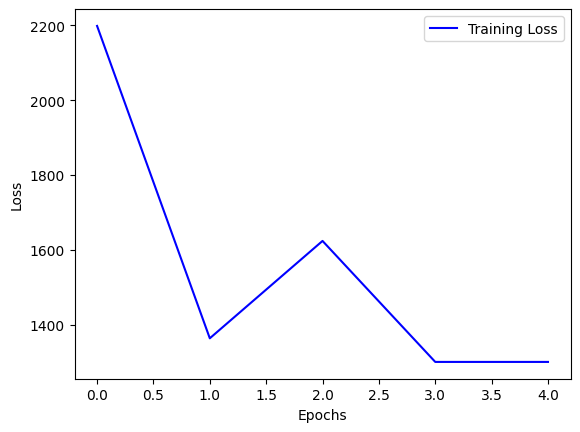

In [15]:
plt.plot(np.arange(len(train_loss)), train_loss, 'b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make some predictions :O

Do some fine tuning for the model as necessary

In [17]:
def decode_audio(encoder, decoder, audio, diff):
    print("b")
    enc_out, states = encoder(audio)
    out, _, _ = decoder(enc_out, states, diff)

    return out

In [18]:
enc.load_state_dict(torch.load('encoder.pth'))
dec.load_state_dict(torch.load('decoder.pth'))

<All keys matched successfully>

In [ ]:
test_loss = 0
num_samples = 1

for i, sample in enumerate(test_dl):
    x = sample[0].to(device)
    diff = sample[1].to(device)
    y = sample[2].to(device)
    decoded_map = decode_audio(enc, dec, x, diff)
    print("Original Decoded Map:")
    print(decoded_map.shape)
    decoded_map = decoded_map[:y.shape[0], :]
    print("Actual: ")
    print(y.shape)
    print("Predicted: ")
    print(decoded_map.shape)
    if not y.shape == decoded_map.shape:
        print("Shapes do not match. Disregarding.")
        continue
    curr_loss = nn.MSELoss()(y, decoded_map)
    test_loss += curr_loss
test_loss /= num_samples
print(f"Average Testing Loss: {test_loss}")

files length: 917, index: 624
filename: 476455_1
b
Requires 5856 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Original Decoded Map:
torch.Size([5856, 8])
Actual: 
torch.Size([5043, 8])
Predicted: 
torch.Size([5043, 8])
files length: 917, index: 129
filename: 938316_9
b
Requires 20010 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Original Decoded Map:
torch.Size([20010, 8])
Actual: 
torch.Size([18916, 8])
Predicted: 
torch.Size([18916, 8])
files length: 917, index: 339


/tmp/ipykernel_49631/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 456072_3
b
Requires 12766 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Original Decoded Map:
torch.Size([12766, 8])
Actual: 
torch.Size([12091, 8])
Predicted: 
torch.Size([12091, 8])
files length: 917, index: 405
filename: 435467_1
b
Requires 21325 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Timestep: 21000
Original Decoded Map:
torch.Size([21325, 8])
Actual: 
torch.Size([20687, 8])
Predicted: 
torch.Size([20687, 8])
files length: 917, index: 99
filename: 120646_1
b
Requires 8976 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timeste

/tmp/ipykernel_49631/470974641.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=targetSampleRate)
/home/kitsu_/Desktop/coding/osu-beatmap-generator/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


filename: 402631_1
b
Requires 9032 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Original Decoded Map:
torch.Size([9032, 8])
Actual: 
torch.Size([8524, 8])
Predicted: 
torch.Size([8524, 8])
files length: 917, index: 231


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_3
b
Requires 29726 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Timestep: 21000
Timestep: 22000
Timestep: 23000
Timestep: 24000
Timestep: 25000
Timestep: 26000
Timestep: 27000
Timestep: 28000
Timestep: 29000
Original Decoded Map:
torch.Size([29726, 8])
Actual: 
torch.Size([28612, 8])
Predicted: 
torch.Size([28612, 8])
files length: 917, index: 666


[src/libmpg123/id3.c:INT123_parse_new_id3():1070] error: ID3v2: non-syncsafe size of APIC frame, skipping the remainder of tag


filename: 243819_1
b
Requires 21055 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Timestep: 21000
Original Decoded Map:
torch.Size([21055, 8])
Actual: 
torch.Size([20635, 8])
Predicted: 
torch.Size([20635, 8])
files length: 917, index: 916
filename: 640271_0
b
Requires 24622 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Timestep: 21000
Timestep: 22000
Timestep: 23000
Timestep: 24000
Original Decoded Map:
torch.Size([24622, 8])
Actual: 
torch.Si

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


filename: 347023_2
b
Requires 29726 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Timestep: 6000
Timestep: 7000
Timestep: 8000
Timestep: 9000
Timestep: 10000
Timestep: 11000
Timestep: 12000
Timestep: 13000
Timestep: 14000
Timestep: 15000
Timestep: 16000
Timestep: 17000
Timestep: 18000
Timestep: 19000
Timestep: 20000
Timestep: 21000
Timestep: 22000
Timestep: 23000
Timestep: 24000
Timestep: 25000
Timestep: 26000
Timestep: 27000
Timestep: 28000
Timestep: 29000
Original Decoded Map:
torch.Size([29726, 8])
Actual: 
torch.Size([28612, 8])
Predicted: 
torch.Size([28612, 8])
files length: 917, index: 166
filename: 926189_0
b
Requires 3938 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Original Decoded Map:
torch.Size([3938, 8])
Actual: 
torch.Size([3884, 8])
Predicted: 
torch.Size([3884, 8])
files length: 917, index: 673
filename: 675779_5
b
Requires 29312 iterations
Timestep: 1000
Timestep: 2000
Timestep: 3000
Timestep: 4000
Timestep: 5000
Time

## Evaluate that bish B)

In [ ]:
full_enc = Encoder(0.4).to(device)
full_dec = Decoder(0.4).to(device)
a2m_dl = DataLoader(a2m_data, batch_size = None, batch_sampler = None, shuffle = True)

full_train_loss = train(a2m_dl, enc, dec, epochs=5)

In [ ]:
plt.plot(np.arange(len(full_train_loss)), full_train_loss, 'b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
full_test_loss = 0
num_samples = 1

for i, sample in enumerate(test_dl):
    x = sample[0].to(device)
    diff = sample[1].to(device)
    y = sample[2].to(device)
    decoded_map = decode_audio(enc, dec, x, diff, y)[:y.shape[0]]
    print("Actual: ")
    print(y)
    print("Predicted: ")
    print(decoded_map)
    curr_loss = nn.MSELoss()(y, decoded_map)
    print(curr_loss)
    full_test_loss += curr_loss
full_test_loss /= num_samples
print(f"Average Testing Loss: {full_test_loss}")